In [1]:
import re
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

from reading_evaluator import (
    extract_reading_tasks,
    sanitize_reading_task_names,
    summarize_reading_times,
    add_correctness,
    summarize_reading_performance,
    plot_reading_task_performance,
    plot_reading_participant_performance
)

from duration_processor import load_quiz_data


# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)


In [2]:
# 假设 df_tasks 已经由 extract_reading_tasks 得到
df_tasks = extract_reading_tasks(all_data, format_list=['json', 'xml', 'hjson', 'yaml','jsonc', 'json5', 'toml'])

# # 2. （可选）查看清理前后的 task 名
# print("原始 task:", df_tasks['task'].unique()[:5])
# df_clean = sanitize_reading_task_names(df_tasks)
# print("清理后 task:", df_clean['task_clean'].unique()[:5])

# 3. 计算并查看各 format×task 平均时长
df_task_avg, df_part_avg = summarize_reading_times(df_tasks)
print("\nAverage duration per format and task:")
print(df_task_avg)

# 4. 查看各 format 下平均总时长（所有 task 累加后）
print("\nAverage total duration per participant by format:")
print(df_part_avg)

correct_answers = {
    'reading-task-tabular-1': 87,
    'reading-task-tabular-2': 'quiz2',
    'reading-task-tabular-3': 4,
    'reading-task-tabular-4': 'Bob',
    'reading-task-tabular-5': ['[Bob, Eve]', 'Alice']
}


df = add_correctness(df_tasks, correct_answers)

# 检查 tabular-5 的几行
print(df[df['task_clean']=='reading-task-tabular-5'][['q','correct']])
df_tasks = extract_reading_tasks(all_data, format_list=['hjson','json','xml'])
df_user = df_tasks[df_tasks['participantId']=='6697c8b6d9d7baa7edd8c4d3'].copy()
df_user = sanitize_reading_task_names(df_user)
df_user = add_correctness(df_user, correct_answers)
print(df_user[['task_clean','q','correct']])


Average duration per format and task:
   format                    task  average_duration_sec
0   hjson  reading-task-tabular-1            111.176733
1   hjson  reading-task-tabular-2             86.460867
2   hjson  reading-task-tabular-3             54.659533
3   hjson  reading-task-tabular-4             66.200133
4   hjson  reading-task-tabular-5            104.186867
5    json  reading-task-tabular-1            136.754294
6    json  reading-task-tabular-2             74.570647
7    json  reading-task-tabular-3             46.783882
8    json  reading-task-tabular-4             46.614353
9    json  reading-task-tabular-5             82.007647
10  json5  reading-task-tabular-1            114.818933
11  json5  reading-task-tabular-2             82.715867
12  json5  reading-task-tabular-3             78.219933
13  json5  reading-task-tabular-4             76.639733
14  json5  reading-task-tabular-5            103.814533
15  jsonc  reading-task-tabular-1             73.894800
16  jsonc

/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_63909/1444685105.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_63909/1444685105.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


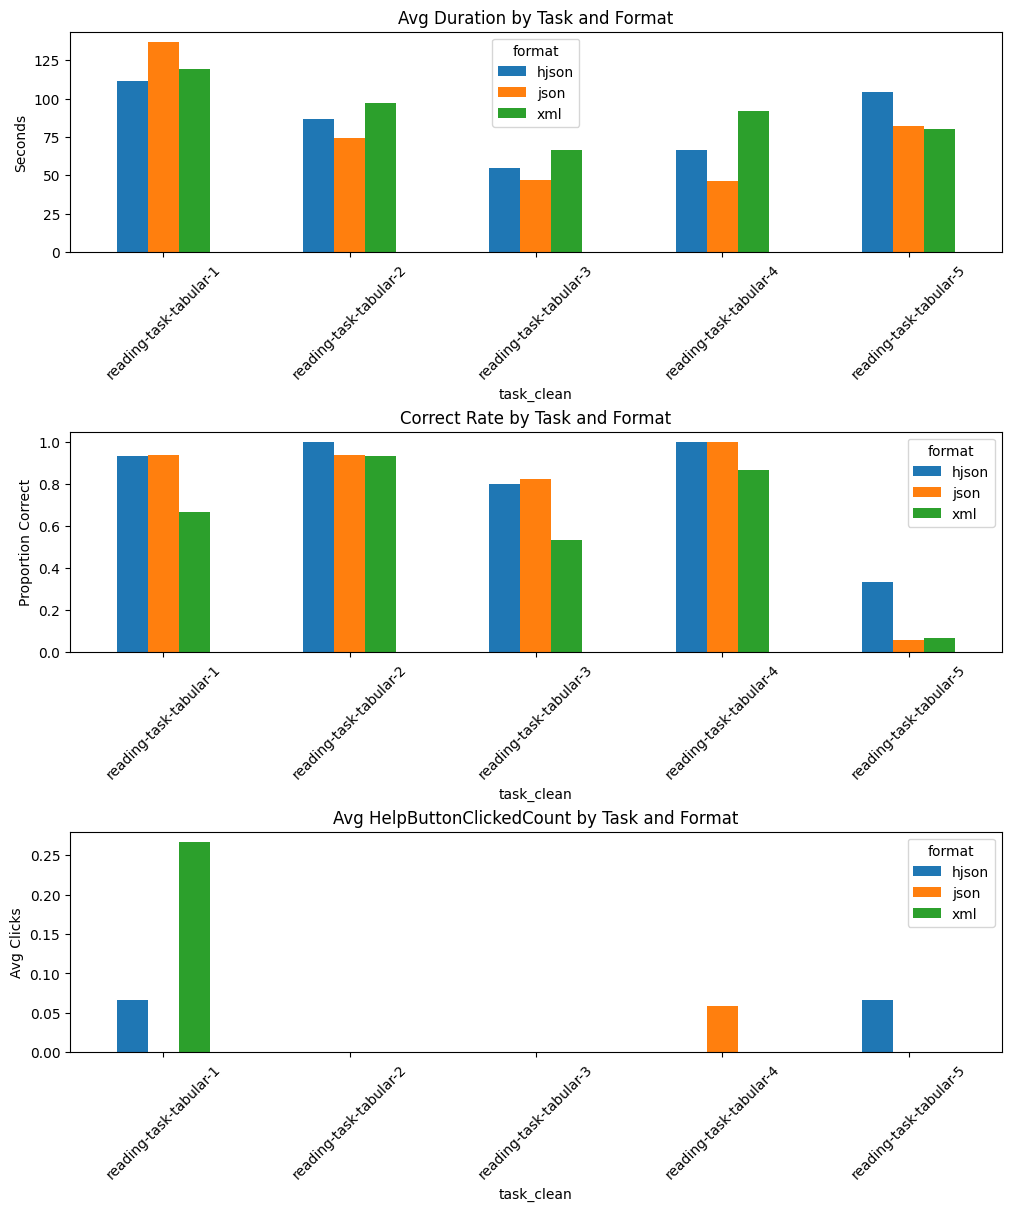

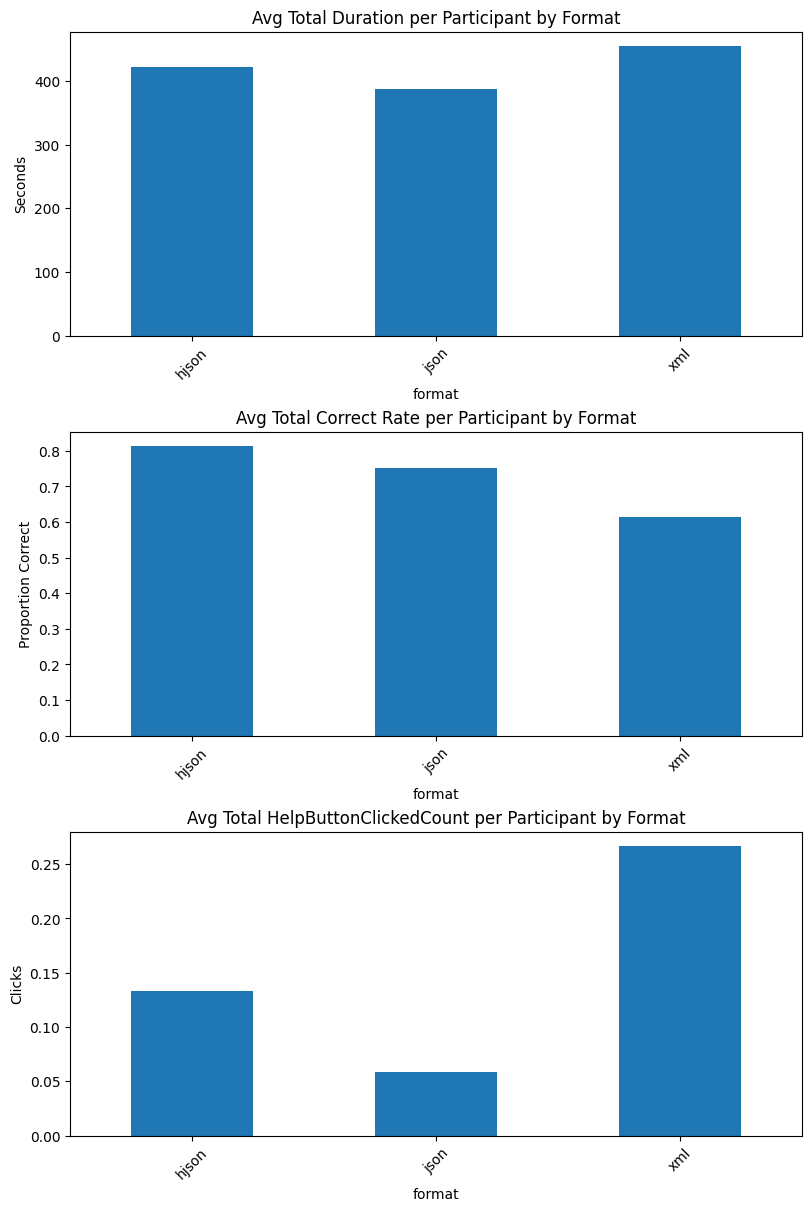

In [3]:
df_task_perf, df_part_perf = summarize_reading_performance(df_tasks, correct_answers)

# 应该不再报 ImportError
fig1 = plot_reading_task_performance(df_task_perf)
fig2 = plot_reading_participant_performance(df_part_perf)
fig1.show()
fig2.show()

In [4]:
import re
import pandas as pd
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def process_clean_post_tasks(df: pd.DataFrame) -> pd.DataFrame:
    """
    1) 在原始 DataFrame 上新增一列 task_group，初始等于 task_clean，
       用于后续分组检验。
    2) 对于所有以
       - 'reading-task-tabular-<n>'
       - 'modifying-task-tabular-<n>'
       开头的子任务，分别按 participantId+format 汇总成
       'reading-task-tabular' & 'modifying-task-tabular' 两个顶层任务：
         * duration_sec           求和
         * helpButtonClickedCount 求和
         * correct                平均
    3) 最终返回一个包含「原始行」+「新增聚合行」的 DataFrame，
       列包括：
       ['participantId','format','task_clean','task_group',
        'duration_sec','helpButtonClickedCount','correct']
    """
    df_work = df.copy()
    df_work['task_group'] = df_work['task_clean']
    
    agg_frames = []
    for prefix in ('reading-task-tabular', 'modifying-task-tabular'):
        mask = df_work['task_clean'].str.match(rf'^{prefix}-\d+$')
        if not mask.any():
            continue
        tmp = df_work[mask]
        summary = (
            tmp
            .groupby(['participantId','format'], as_index=False)
            .agg({
                'duration_sec':           'sum',
                'helpButtonClickedCount': 'sum',
                'correct':                'mean'
            })
        )
        summary['task_group'] = prefix
        agg_frames.append(summary[[
            'participantId','format','task_group',
            'duration_sec','helpButtonClickedCount','correct'
        ]])
    
    # 原始行只保留需要的列
    df_orig = df_work[[
        'participantId','format','task_clean','task_group',
        'duration_sec','helpButtonClickedCount','correct'
    ]]
    
    df_combined = pd.concat([df_orig] + agg_frames, ignore_index=True, sort=False)
    return df_combined


def test_task_group_by_format(
    df: pd.DataFrame,
    metrics: list = None,
    group_col: str = 'task_group',
    alpha: float = 0.05
) -> dict:
    """
    对每个 task_group 下，不同 format 的三个指标做组间差异检验。
    如果某组(metric)所有值都相同，则直接返回 stat=0, p=1 当作“无差异”。
    """
    if metrics is None:
        metrics = ['duration_sec','helpButtonClickedCount','correct']
    
    results = {}
    for tg in df[group_col].unique():
        df_t = df[df[group_col] == tg]
        if df_t['format'].nunique() < 2:
            continue
        results[tg] = {}
        
        for metric in metrics:
            if metric not in df_t.columns:
                continue
            sub = df_t[['format', metric]].dropna()
            # --- 常数情形检测 ---
            all_vals = sub[metric].values
            if len(all_vals) > 0 and pd.Series(all_vals).nunique() == 1:
                # 直接标记“无差异”
                interp = (
                    f"Task '{tg}' — metric '{metric}' has constant value "
                    f"{all_vals[0]} across all formats: no difference."
                )
                results[tg][metric] = {
                    'levene': None,
                    'method': 'constant',
                    'stat': 0.0,
                    'p_value': 1.0,
                    'tukey': None,
                    'interpretation': interp
                }
                continue
            
            # 正常走 Levene → ANOVA/Kruskal
            groups = [g[metric].values for _, g in sub.groupby('format')]
            w_stat, p_levene = levene(*groups)
            if p_levene > alpha:
                stat, pval = f_oneway(*groups)
                method = 'ANOVA'
            else:
                try:
                    stat, pval = kruskal(*groups)
                except ValueError:
                    stat, pval = 0.0, 1.0
                method = 'Kruskal–Wallis'
            
            # 事后 Tukey
            tukey = None
            if method == 'ANOVA' and pval < alpha:
                tukey = pairwise_tukeyhsd(
                    endog=sub[metric],
                    groups=sub['format'],
                    alpha=alpha
                )
            
            # 解读
            var_msg = (
                f"Task '{tg}' — Levene’s test on {metric}: "
                f"p = {p_levene:.3f} "
                f"({'homogeneous' if p_levene>alpha else 'heterogeneous'}) variances."
            )
            if pval < alpha:
                main_msg = (
                    f"{method} on {metric}: p = {pval:.3f} (< {alpha}), "
                    "formats differ significantly."
                )
                if tukey is not None:
                    main_msg += " See Tukey HSD for pairwise."
            else:
                main_msg = (
                    f"{method} on {metric}: p = {pval:.3f} (≥ {alpha}), "
                    "no significant differences among formats."
                )
            interp = var_msg + " " + main_msg
            
            results[tg][metric] = {
                'levene':    (w_stat, p_levene),
                'method':    method,
                'stat':      stat,
                'p_value':   pval,
                'tukey':     tukey,
                'interpretation': interp
            }
    return results


# 1. 先把原始和聚合后的行都做好（比如用你已有的 process_clean_post_tasks）
df_processed = process_clean_post_tasks(df)

# 2. 对 task_clean 进行组间检验
results = test_task_group_by_format(
    df_processed,
    metrics=['duration_sec','helpButtonClickedCount','correct']
)

# 打印所有 task_group 下的检验解读：
for task_group, metrics_dict in results.items():
    print(f"\n=== Task: {task_group} ===")
    for metric, info in metrics_dict.items():
        print(info['interpretation'])
        if info['tukey'] is not None:
            print(info['tukey'].summary())



=== Task: reading-task-tabular-1 ===
Task 'reading-task-tabular-1' — Levene’s test on duration_sec: p = 0.338 (homogeneous) variances. ANOVA on duration_sec: p = 0.185 (≥ 0.05), no significant differences among formats.
Task 'reading-task-tabular-1' — Levene’s test on helpButtonClickedCount: p = 0.249 (homogeneous) variances. ANOVA on helpButtonClickedCount: p = 0.249 (≥ 0.05), no significant differences among formats.
Task 'reading-task-tabular-1' — Levene’s test on correct: p = 0.412 (homogeneous) variances. ANOVA on correct: p = 0.412 (≥ 0.05), no significant differences among formats.

=== Task: reading-task-tabular-2 ===
Task 'reading-task-tabular-2' — Levene’s test on duration_sec: p = 0.732 (homogeneous) variances. ANOVA on duration_sec: p = 0.694 (≥ 0.05), no significant differences among formats.
Task 'reading-task-tabular-2' — metric 'helpButtonClickedCount' has constant value 0 across all formats: no difference.
Task 'reading-task-tabular-2' — Levene’s test on correct: p = 

=== Detailed Interpretations ===

--- Task: reading-task-tabular ---
Task 'reading-task-tabular', metric 'helpButtonClickedCount': One-way ANOVA F=1.314, p=0.258. No significant difference.
Task 'reading-task-tabular', metric 'correct': One-way ANOVA F=2.683, p=0.019. Significant.
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 hjson   json  -0.0604 0.9649 -0.2536  0.1328  False
 hjson  json5    -0.12 0.5421 -0.3191  0.0791  False
 hjson  jsonc  -0.1067 0.6748 -0.3058  0.0925  False
 hjson   toml  -0.0705 0.9416 -0.2731  0.1322  False
 hjson    xml     -0.2 0.0483 -0.3991 -0.0009   True
 hjson   yaml  -0.2133 0.0275 -0.4125 -0.0142   True
  json  json5  -0.0596  0.967 -0.2528  0.1336  False
  json  jsonc  -0.0463  0.991 -0.2395  0.1469  False
  json   toml  -0.0101    1.0 -0.2069  0.1867  False
  json    xml  -0.1396 0.3184 -0.3328  0.0536  False
  json   yaml  -0.1529 0.2169

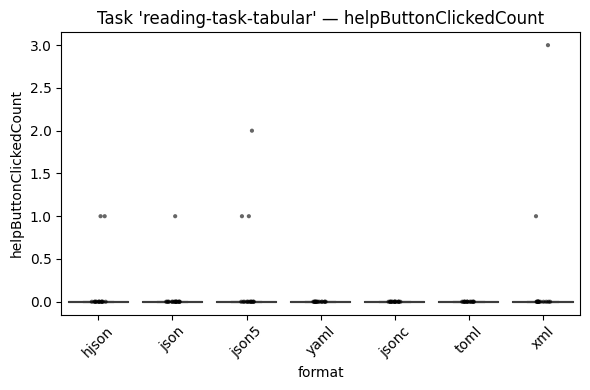

Outliers for 'reading-task-tabular', metric 'helpButtonClickedCount':
              participantId format  helpButtonClickedCount outlier_group  \
0  6577a27da9f5297d49f38e6f  hjson                       1         hjson   
1  67adb27bd5f5776fcb16da62  hjson                       1         hjson   
2  67e571bef6af7ecd9c29ad72   json                       1          json   
3  5b68c9eb87af310001584803  json5                       2         json5   
4  6606b31155457e4f162ecf5a  json5                       1         json5   
5  6788c1c724c24dc56b08790a  json5                       1         json5   
6  66bb6b7e0ccbed81f3ed30a8    xml                       3           xml   
7  67d95269b47464c18da766ca    xml                       1           xml   

   lower_bound  upper_bound  
0          0.0          0.0  
1          0.0          0.0  
2          0.0          0.0  
3          0.0          0.0  
4          0.0          0.0  
5          0.0          0.0  
6          0.0          0.0  
7    

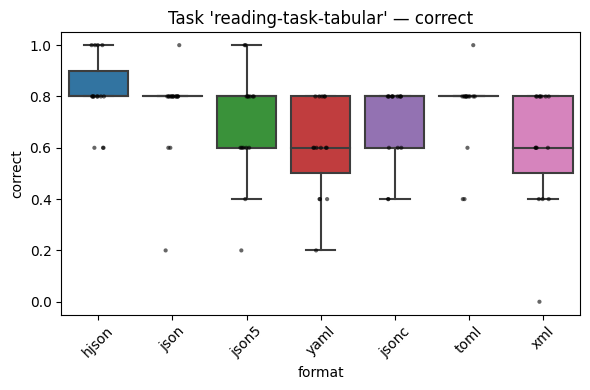

Outliers for 'reading-task-tabular', metric 'correct':
               participantId format  correct outlier_group  lower_bound  \
0   67adb27bd5f5776fcb16da62  hjson      0.6         hjson         0.65   
1   67d71acca9143c53ef722a5c  hjson      0.6         hjson         0.65   
2   67d7fa657f5ac0292a291a38  hjson      0.6         hjson         0.65   
3   60f1f1d4ac991a259b83f603   json      0.6          json         0.80   
4   65be552ceed6a0595fa1feb5   json      0.6          json         0.80   
5   667ac09492ea0caadf488520   json      0.2          json         0.80   
6   66b0d065329001a04e5ae671   json      1.0          json         0.80   
7   67d548b5aa5737666a77a6d2  json5      0.2         json5         0.30   
8   5e8a5a892f6f027054a83d88   toml      0.6          toml         0.80   
9   672a844656ca03498e04cd76   toml      0.4          toml         0.80   
10  67bf88cc763aae600b429a3e   toml      1.0          toml         0.80   
11  67eefd0739d752c54dd52686   toml      0.4 

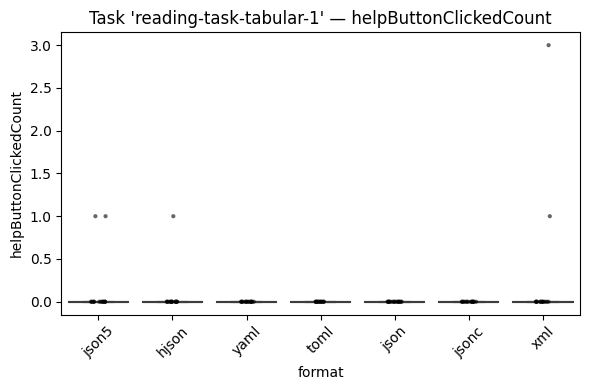

Outliers for 'reading-task-tabular-1', metric 'helpButtonClickedCount':
              participantId format  helpButtonClickedCount outlier_group  \
0  6577a27da9f5297d49f38e6f  hjson                       1         hjson   
1  6788c1c724c24dc56b08790a  json5                       1         json5   
2  6606b31155457e4f162ecf5a  json5                       1         json5   
3  67d95269b47464c18da766ca    xml                       1           xml   
4  66bb6b7e0ccbed81f3ed30a8    xml                       3           xml   

   lower_bound  upper_bound  
0          0.0          0.0  
1          0.0          0.0  
2          0.0          0.0  
3          0.0          0.0  
4          0.0          0.0  
------------------------------


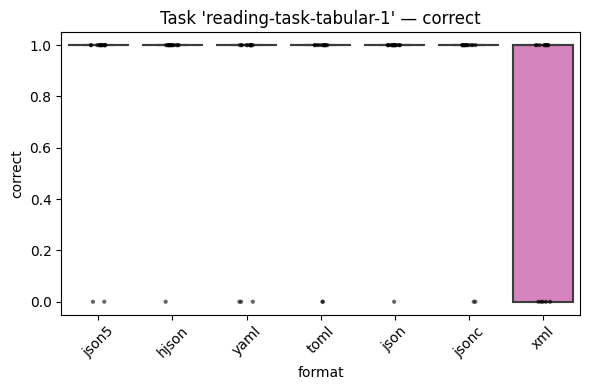

Outliers for 'reading-task-tabular-1', metric 'correct':
               participantId format  correct outlier_group  lower_bound  \
0   67d71acca9143c53ef722a5c  hjson      0.0         hjson          1.0   
1   667ac09492ea0caadf488520   json      0.0          json          1.0   
2   64457bc906c125cebd4bf66b  json5      0.0         json5          1.0   
3   67d548b5aa5737666a77a6d2  json5      0.0         json5          1.0   
4   66781db404eab5e142f849d9  jsonc      0.0         jsonc          1.0   
5   67ab650c320eccf6141d4010  jsonc      0.0         jsonc          1.0   
6   672a844656ca03498e04cd76   toml      0.0          toml          1.0   
7   67eefd0739d752c54dd52686   toml      0.0          toml          1.0   
8   67dc19c31078d1581e39e75a   yaml      0.0          yaml          1.0   
9   67d29234dbfdb6668d124115   yaml      0.0          yaml          1.0   
10  672003022f1b667a20157c45   yaml      0.0          yaml          1.0   

    upper_bound  
0           1.0  
1     

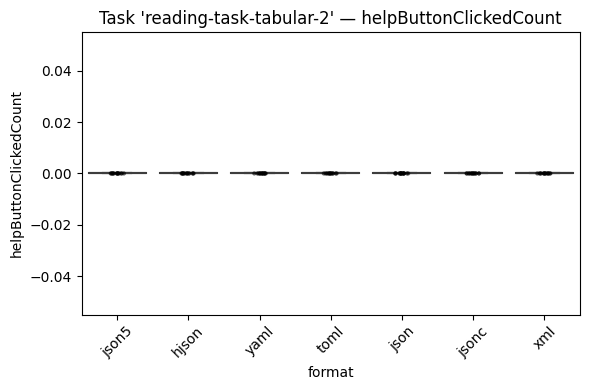

No outliers for 'reading-task-tabular-2', metric 'helpButtonClickedCount'.
------------------------------


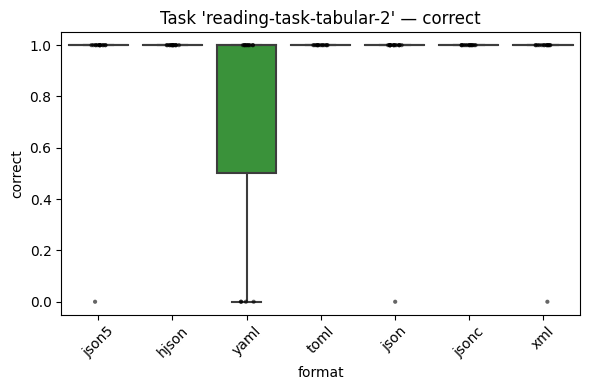

Outliers for 'reading-task-tabular-2', metric 'correct':
              participantId format  correct outlier_group  lower_bound  \
0  667ac09492ea0caadf488520   json      0.0          json          1.0   
1  67d163e7b7bcc1e9718e01da  json5      0.0         json5          1.0   
2  67e4920c40c9561040ca01d0    xml      0.0           xml          1.0   

   upper_bound  
0          1.0  
1          1.0  
2          1.0  
------------------------------

--- Task: reading-task-tabular-3 ---


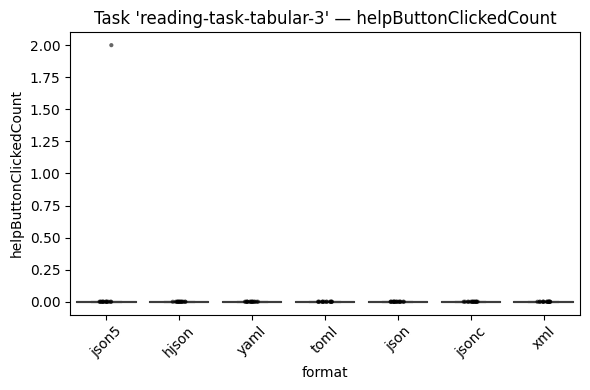

Outliers for 'reading-task-tabular-3', metric 'helpButtonClickedCount':
              participantId format  helpButtonClickedCount outlier_group  \
0  5b68c9eb87af310001584803  json5                       2         json5   

   lower_bound  upper_bound  
0          0.0          0.0  
------------------------------


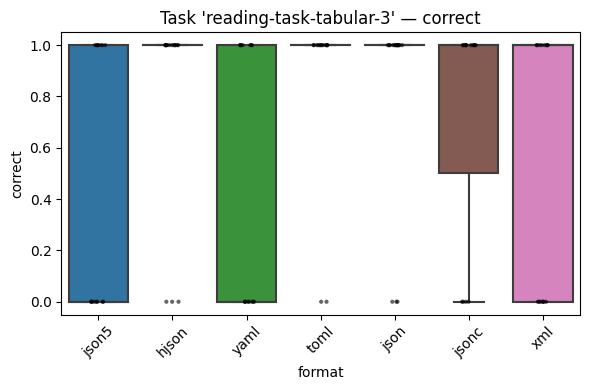

Outliers for 'reading-task-tabular-3', metric 'correct':
              participantId format  correct outlier_group  lower_bound  \
0  67d7fa657f5ac0292a291a38  hjson      0.0         hjson          1.0   
1  67d71acca9143c53ef722a5c  hjson      0.0         hjson          1.0   
2  67adb27bd5f5776fcb16da62  hjson      0.0         hjson          1.0   
3  60f1f1d4ac991a259b83f603   json      0.0          json          1.0   
4  667ac09492ea0caadf488520   json      0.0          json          1.0   
5  65be552ceed6a0595fa1feb5   json      0.0          json          1.0   
6  5e8a5a892f6f027054a83d88   toml      0.0          toml          1.0   
7  67eefd0739d752c54dd52686   toml      0.0          toml          1.0   

   upper_bound  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  
5          1.0  
6          1.0  
7          1.0  
------------------------------

--- Task: reading-task-tabular-4 ---


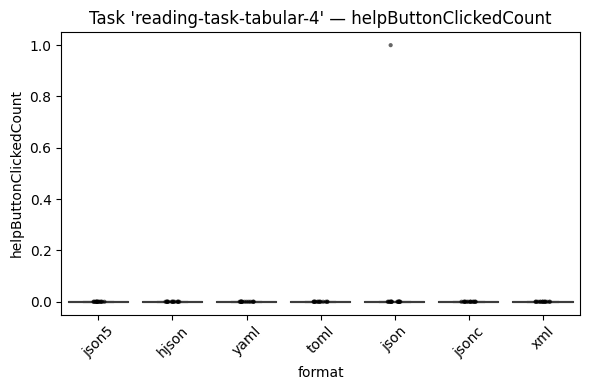

Outliers for 'reading-task-tabular-4', metric 'helpButtonClickedCount':
              participantId format  helpButtonClickedCount outlier_group  \
0  67e571bef6af7ecd9c29ad72   json                       1          json   

   lower_bound  upper_bound  
0          0.0          0.0  
------------------------------


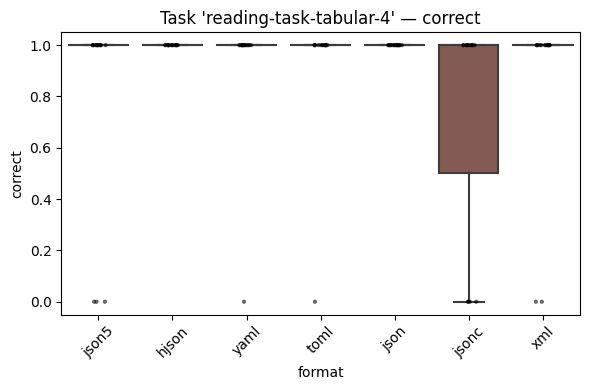

Outliers for 'reading-task-tabular-4', metric 'correct':
              participantId format  correct outlier_group  lower_bound  \
0  672ca6c0324ac26cdc0dd298  json5      0.0         json5          1.0   
1  67d548b5aa5737666a77a6d2  json5      0.0         json5          1.0   
2  6787d648d7b1963c661f9443  json5      0.0         json5          1.0   
3  672a844656ca03498e04cd76   toml      0.0          toml          1.0   
4  67e4920c40c9561040ca01d0    xml      0.0           xml          1.0   
5  677d32c679491be18090225b    xml      0.0           xml          1.0   
6  67d29234dbfdb6668d124115   yaml      0.0          yaml          1.0   

   upper_bound  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  
5          1.0  
6          1.0  
------------------------------

--- Task: reading-task-tabular-5 ---


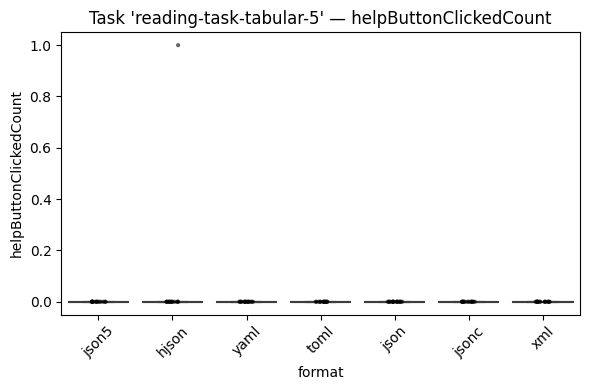

Outliers for 'reading-task-tabular-5', metric 'helpButtonClickedCount':
              participantId format  helpButtonClickedCount outlier_group  \
0  67adb27bd5f5776fcb16da62  hjson                       1         hjson   

   lower_bound  upper_bound  
0          0.0          0.0  
------------------------------


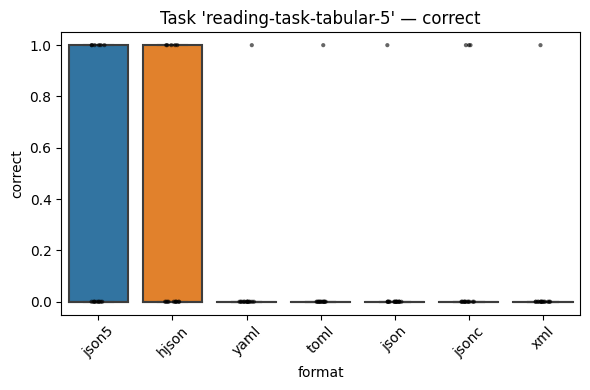

Outliers for 'reading-task-tabular-5', metric 'correct':
              participantId format  correct outlier_group  lower_bound  \
0  66b0d065329001a04e5ae671   json      1.0          json          0.0   
1  677d185800ab83d1b0185d82  jsonc      1.0         jsonc          0.0   
2  5f16f559325a640008bb9a07  jsonc      1.0         jsonc          0.0   
3  67ab650c320eccf6141d4010  jsonc      1.0         jsonc          0.0   
4  67bf88cc763aae600b429a3e   toml      1.0          toml          0.0   
5  677d32c679491be18090225b    xml      1.0           xml          0.0   
6  67d29234dbfdb6668d124115   yaml      1.0          yaml          0.0   

   upper_bound  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
5          0.0  
6          0.0  
------------------------------

=== Summary DataFrame ===
                task_group                  metric          method       stat  \
0     reading-task-tabular  helpButtonClickedCount           ANOVA   1.3140

In [6]:
import re
import pandas as pd
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

def process_clean_post_tasks(df: pd.DataFrame) -> pd.DataFrame:
    """
    1) Copy `task_clean` into a new `task_group` column.
    2) Aggregate subtasks `reading-task-tabular-<n>` and
       `modifying-task-tabular-<n>` into their prefixes:
         • duration_sec           sum
         • helpButtonClickedCount sum
         • correct                mean
    3) Return original + aggregated rows.
    """
    df_work = df.copy()
    df_work['task_group'] = df_work['task_clean']
    
    agg_frames = []
    for prefix in ('reading-task-tabular', 'modifying-task-tabular'):
        mask = df_work['task_clean'].str.match(rf'^{prefix}-\d+$')
        if not mask.any():
            continue
        tmp = df_work[mask]
        summary = (
            tmp
            .groupby(['participantId','format'], as_index=False)
            .agg({
                'duration_sec':           'sum',
                'helpButtonClickedCount': 'sum',
                'correct':                'mean'
            })
        )
        summary['task_group'] = prefix
        agg_frames.append(summary)
    
    df_orig = df_work[[
        'participantId','format','task_clean','task_group',
        'duration_sec','helpButtonClickedCount','correct'
    ]]
    df_combined = pd.concat([df_orig] + agg_frames, ignore_index=True, sort=False)
    return df_combined

def test_task_group_by_format(
    df: pd.DataFrame,
    task_list: list = None,
    metrics: list = None,
    group_col: str = 'task_group',
    format_col: str = 'format',
    alpha: float = 0.05
) -> dict:
    """
    For each task_group in `task_list` (or all if None), test each metric in `metrics`
    across formats:
      - If all values constant → mark constant (p=1)
      - Else Levene → ANOVA or Kruskal–Wallis
      - If ANOVA & p<alpha → Tukey HSD
    Returns nested dict: results[task_group][metric] = {…}
    """
    if task_list is None:
        task_list = df[group_col].unique().tolist()
    if metrics is None:
        metrics = ['duration_sec','helpButtonClickedCount','correct']
    
    results = {}
    for tg in task_list:
        df_t = df[df[group_col] == tg]
        if df_t[format_col].nunique() < 2:
            continue
        results[tg] = {}
        for metric in metrics:
            if metric not in df_t.columns:
                continue
            sub = df_t[['format', metric]].dropna()
            vals = sub[metric].values
            
            # constant check
            if len(vals) > 0 and pd.Series(vals).nunique() == 1:
                interp = (f"Task '{tg}', metric '{metric}' is constant "
                          f"({vals[0]}): no differences.")
                results[tg][metric] = {
                    'method': 'constant',
                    'stat': 0.0,
                    'p_value': 1.0,
                    'tukey': None,
                    'interpretation': interp
                }
                continue
            
            # Levene's test
            groups = [g[metric].values for _, g in sub.groupby(format_col)]
            w_stat, p_levene = levene(*groups)
            
            # select test
            if p_levene > alpha:
                stat, pval = f_oneway(*groups)
                method = 'ANOVA'
            else:
                try:
                    stat, pval = kruskal(*groups)
                except ValueError:
                    stat, pval = 0.0, 1.0
                method = 'Kruskal–Wallis'
            
            # Tukey if ANOVA & significant
            tukey = None
            if method == 'ANOVA' and pval < alpha:
                tukey = pairwise_tukeyhsd(
                    endog=sub[metric],
                    groups=sub['format'],
                    alpha=alpha
                )
            
            # interpretation
            if method == 'ANOVA':
                interp = (f"Task '{tg}', metric '{metric}': One-way ANOVA F={stat:.3f}, "
                          f"p={pval:.3f}. "
                          f"{'Significant.' if pval<alpha else 'No significant difference.'}")
            else:
                interp = (f"Task '{tg}', metric '{metric}': Kruskal–Wallis H={stat:.3f}, "
                          f"p={pval:.3f}. "
                          f"{'Significant.' if pval<alpha else 'No significant difference.'}")
            
            results[tg][metric] = {
                'method': method,
                'stat': stat,
                'p_value': pval,
                'tukey': tukey,
                'interpretation': interp
            }
    return results

def extract_outliers(
    df: pd.DataFrame,
    group_col: str,
    value_col: str
) -> pd.DataFrame:
    """
    Outliers by 1.5*IQR per group.
    """
    outliers = []
    for g, grp in df.groupby(group_col):
        q1, q3 = grp[value_col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
        mask = (grp[value_col] < lb) | (grp[value_col] > ub)
        tmp = grp[mask].copy()
        if not tmp.empty:
            tmp['outlier_group'] = g
            tmp['lower_bound'], tmp['upper_bound'] = lb, ub
            outliers.append(tmp)
    return pd.concat(outliers, ignore_index=True) if outliers else pd.DataFrame()

def report_task_group_analysis(
    df: pd.DataFrame,
    tasks: list,
    metrics: list = None,
    group_col: str = 'task_group',
    format_col: str = 'format',
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    1) Run tests & print interpretations
    2) Print summary of significant metrics & Tukey pairs
    3) Plot boxplots + stripplots & outliers
    4) Return summary DataFrame with columns:
       [task_group, metric, method, stat, p_value, significant, diff_pairs]
    """
    # 1) testing
    results = test_task_group_by_format(
        df,
        task_list=tasks,
        metrics=metrics,
        group_col=group_col,
        format_col=format_col,
        alpha=alpha
    )
    
    # 2) print interpretations
    print("=== Detailed Interpretations ===")
    for tg in tasks:
        if tg not in results:
            print(f"Task '{tg}': no data or insufficient formats.")
            continue
        print(f"\n--- Task: {tg} ---")
        for metric, info in results[tg].items():
            print(info['interpretation'])
            if info['tukey'] is not None:
                print(info['tukey'].summary(), "\n")
    
    # 3) summary of significance
    rows = []
    print("\n=== Summary of Significant Metrics ===")
    for tg, met_dict in results.items():
        sig = [m for m,i in met_dict.items() if i['p_value'] < alpha]
        nonsig = [m for m,i in met_dict.items() if i['p_value'] >= alpha]
        print(f"Task '{tg}': significant → {sig}; not significant → {nonsig}")
        for metric in met_dict:
            info = met_dict[metric]
            # collect Tukey pairs
            pairs = []
            if info['method']=='ANOVA' and info['tukey'] is not None:
                for r in info['tukey'].summary().data[1:]:
                    if r[-1] in (True,'True'):
                        pairs.append(f"{r[0]} vs {r[1]}")
            rows.append({
                'task_group': tg,
                'metric': metric,
                'method': info['method'],
                'stat': info['stat'],
                'p_value': info['p_value'],
                'significant': info['p_value'] < alpha,
                'diff_pairs': pairs
            })
    
    # 4) visualization & outliers
    print("\n=== Boxplots & Outliers ===")
    for tg in tasks:
        df_t = df[df[group_col] == tg].dropna(subset=[format_col])
        if df_t.empty:
            continue
        print(f"\n--- Task: {tg} ---")
        for metric in metrics or ['duration_sec','helpButtonClickedCount','correct']:
            if metric not in df_t.columns:
                continue
            sub = df_t.dropna(subset=[metric])
            if sub.empty:
                continue
            plt.figure(figsize=(6,4))
            sns.boxplot(x=format_col, y=metric, data=sub, showfliers=False)
            sns.stripplot(x=format_col, y=metric, data=sub,
                          color='black', size=3, alpha=0.6)
            plt.title(f"Task '{tg}' — {metric}")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            out = extract_outliers(sub, format_col, metric)
            if not out.empty:
                print(f"Outliers for '{tg}', metric '{metric}':")
                print(out[['participantId', format_col, metric,
                           'outlier_group','lower_bound','upper_bound']])
            else:
                print(f"No outliers for '{tg}', metric '{metric}'.")
            print("-"*30)
    
    # assemble summary_df
    summary_df = pd.DataFrame(rows)
    print("\n=== Summary DataFrame ===")
    print(summary_df)
    return summary_df

# ======================
# Usage example:
#
df_processed = process_clean_post_tasks(df)
tasks = ['reading-task-tabular',
         'reading-task-tabular-1',
         'reading-task-tabular-2',
         'reading-task-tabular-3',
         'reading-task-tabular-4',
         'reading-task-tabular-5']
summary_df = report_task_group_analysis(
    df_processed,
    tasks,
    metrics=['helpButtonClickedCount','correct'],
    alpha=0.05
)


In [21]:
import pandas as pd

def find_constant_groups(
    df: pd.DataFrame,
    metrics: list = None,
    group_col: str = 'task_group'
) -> pd.DataFrame:
    """
    找出 df 中哪些 (group_col, metric) 对应的数值列所有观测值都相同。
    返回一个 DataFrame，包含 task_group、metric 以及那个唯一值。
    """
    if metrics is None:
        metrics = ['duration_sec','helpButtonClickedCount','correct']
    records = []
    for tg, grp in df.groupby(group_col):
        for m in metrics:
            # 把非数值先 drop，再检查唯一性
            vals = pd.to_numeric(grp[m], errors='coerce').dropna()
            if not vals.empty and vals.nunique() == 1:
                records.append({
                    group_col: tg,
                    'metric': m,
                    'constant_value': vals.iloc[0]
                })
    return pd.DataFrame(records)

# 用法示例
df_processed = process_clean_post_tasks(df)   # 你之前的预处理结果

const_df = find_constant_groups(
    df_processed,
    metrics=['duration_sec','helpButtonClickedCount','correct'],
    group_col='task_group'
)
print(const_df)


               task_group                  metric  constant_value
0  reading-task-tabular-2  helpButtonClickedCount               0
